# Sustainability reports analysis

# Introduzione

L'obiettivo della repository è quello di estrarre informazioni sui bilanci di sostenibilitò delle aziende italiane pubblicati nell'anno 2018.

# Processo
 
Il processo per ottenere l'indice da analizzare è così composto:

1. processing di un file csv contentente siti e web e link presenti su essi
2. download dei file ritenuti utili all'analisi
3. estrazione del testo dai file scaricati
4. indicizzazione elasticsearch con le informazioni trovate sulle aziende e delle entità estratte dai testi dei documenti

# Processing link csv

Il punto di partenza è costituito da un csv con un insieme di coppie __website__ , __pdf_dump__:

- Il primo è il dominio del sito web di cui sono stati estratti i pdf.
- Il secondo è una lista di oggetti che contengono:

    1. Url della pagina a cui è stato trovato il link
    2. Url del file pdf in questione
    3. Anchor del file nella pagina
    4. Sequenza di blocchi html in cui si trova l'anchor
    
L'obbiettivo della prima fase è quello di estrarre dal totale dei link solo quelli utili, ovvero quelli che possono rappresentare un probabile bilancio di sostenibilità 2018.

Prendiamo per semplicità un insieme ridotto e applichiamo il processo in questione.

In [3]:
import pandas as pd

csv_source = "samples/small.csv"

data = pd.read_csv(csv_source) 
data.head()

,domain,pdf_dump
0,www.iav.com,"[{""sourcePageUrl"":""https://www.iav.com/en/comp..."
1,www.enel.com,"[{""sourcePageUrl"":""https://www.enel.com/es/his..."
2,www.icpaoloterzo.edu.it,"[{""sourcePageUrl"":""https://www.icpaoloterzo.ed..."
3,www.cartadaformaggio.it,"[{""sourcePageUrl"":""http://www.cartadaformaggio..."
4,www.cartadimilano.org,"[{""sourcePageUrl"":""http://www.cartadimilano.or..."


La procedura legge da un file di input e restituisce un dizionario contenente:

__website__: lista di __link__, con url e score.

In [12]:
from csv_links_processing import find_reports, get_stats
import json

csv_dest = "samples/dest.csv"
stats_dest = "samples/stats.csv"

links, stats = find_reports(csv_source)

print(json.dumps(links, indent = 2), end = '\n\n')
print(get_stats(stats).replace(',', ': '))

{
  "www.iav.com": [
    {
      "url": "https://www.iav.com/app/uploads/2019/02/IAV_Sustainability_Report_2018.pdf",
      "score": 60
    }
  ],
  "www.enel.com": [
    {
      "url": "https://www.enel.com/content/dam/enel-com/governance_pdf/reports/bilanci-annuali/2018/bilancio-di-sostenibilita-2018.pdf",
      "score": 60
    },
    {
      "url": "https://www.enel.com/content/dam/enel-com/governance_pdf/reports/annual-financial-report/2018/sustainability-report-2018.pdf",
      "score": 60
    }
  ]
}

metric: value
Total websites: 5
Websites who published: 2
Published percentage: 40.000000
Total links: 65
Probable sustainability pdfs links: 3
Useful pdfs percentage: 4.615385
Average depth: 2.000000
Pdfs in homepage: 1


## Valutazione link

Il valore dello score dipende dalla funzione __evaluate__ , che valuta la pertinenza di un link in merito al tema della sostenibilità.

La funzione nello specifico considera il filename, l'url dal quale è stato raggiunto il file e l'anchor, cerca occorrenze di parole chiave e computa uno score, il numero di occorenze di un "anno", in questo caso il 2018, e assegna un valore booleano al link.
$$\newcommand{\pluseq}{\mathrel{+}=}$$
A seguire i criteri per assegnare lo score:
$$"sostenibilita"\;in\;(\,filename\,or\,anchor\,) \implies score \pluseq 40$$
$$"ambiente"\;or\;"bilancio"\;or\;"rapporto"\;in\;(\,filename\,or\,anchor\,) \implies score \pluseq 20$$
$$"sostenibilita"\;or\;"ambiente"\;in\;(\,url\,) \implies score \pluseq 10$$

Dopo aver calcolato il punteggio, nel caso di esempio, e nella versione finale è utilizzata la seguente condizione:

$$tsh \,= \,40$$
$$ \; score \geq tsh, \,"2018"\,  in \; (\, filename \,or\,anchor\,or\,path\,)$$

In [13]:
from csv_links_processing import evaluate

ll = [
    {
        'pdfUrl' : 'www.test.it/sustainability/report-sostenibilità-2018.pdf',
        'anchor' : 'Scarica report sostenibilità'
    },
    {
        'pdfUrl' : 'www.test.it/docs/2018/report-ambientale.pdf',
        'anchor' : 'Download file'
    },
    {
        'pdfUrl' : 'www.test.it/home/documents/bilancio-economico-2018.pdf',
        'anchor' : 'Bilancio economico 2018'
    }
]

for l in ll:
    print("Evaluation: %s \nScore: %d, \n2018 occurrences: %d\n" %evaluate(l))

Evaluation: True 
Score: 70, 
2018 occurrences: 1

Evaluation: True 
Score: 40, 
2018 occurrences: 1

Evaluation: False 
Score: 20, 
2018 occurrences: 2



## Valutazioni alternative

La funzione valuta come positivi i link che hanno ottenuto uno score di almeno __40__ e nei quali si è trovata almeno un occorrenza di 2018 in anchor, filename o path.

Le metriche possibili sono molte, quelle testate per la valutazione sono state le seguenti:

$$tsh \in(\,40, \,60\,)$$

$$(1)\; score \geq tsh, \,"2018"\,  in \; (\, filename \,or\,anchor\,or\,path\,)$$
$$(2)\;score \geq tsh, \,"2018"\,  in \, filename$$
$$(3)\;score \geq tsh,\,"2018"\,in \, anchor$$
$$(4)\;score \geq tsh, \,"2018"\,  in \, (\, filename \,or\,anchor\,)$$
$$(5)\;score \geq tsh$$

Si può notare sempre lo stesso andamento per quanto riguarda le differenze tra le condizioni, mentre la threshold alza o abbassa l'andamento complessivo.

In [2]:
from csv_links_processing import get_plot_stats, generate_plot
import matplotlib.pyplot as plt

stp = get_plot_stats("csv_links_processing/evaluation_tests/data/function")

### Numero di siti web che hanno pubblicato il bilancio
La stima iniziale di siti che hanno pubblicato, ovvero circa 4000, fatta prima di perfezionare la funzione __evaluation__ era evidentemente errata, infatti le parole chiave erano ricercate nell'url completo, compreso di dominio, senza rimuovere i duplicati e senza dare più importanza alla keyword _sostenibilità_.

Il numero di riscontri ora è chiaramente minore, ma si apprezza una pertinenza con il tema della sostenibilità molto più elevata.

### Numero di pdf utili
Si nota che il numero di pdf è sempre maggiore del numero di siti web che pubblicano, questo perchè circa il __18%__ dei siti pubblica un numero che varia da 2 a 4 di pdf che sono ritenuti utili.
Può succedere perchè in alcuni casi sono presenti traduzioni dello stesso file, oppure un riassunto accompagnato dal file completo.

Ritengo che si possa accettare uno scenario del genere per il momento, per poi gestirlo nella successiva parte di analisi semantica del testo, andando ad inserire tutti i file per ogni azienda. 
Sarà poi lo score ad ordinarli per rilevanza.

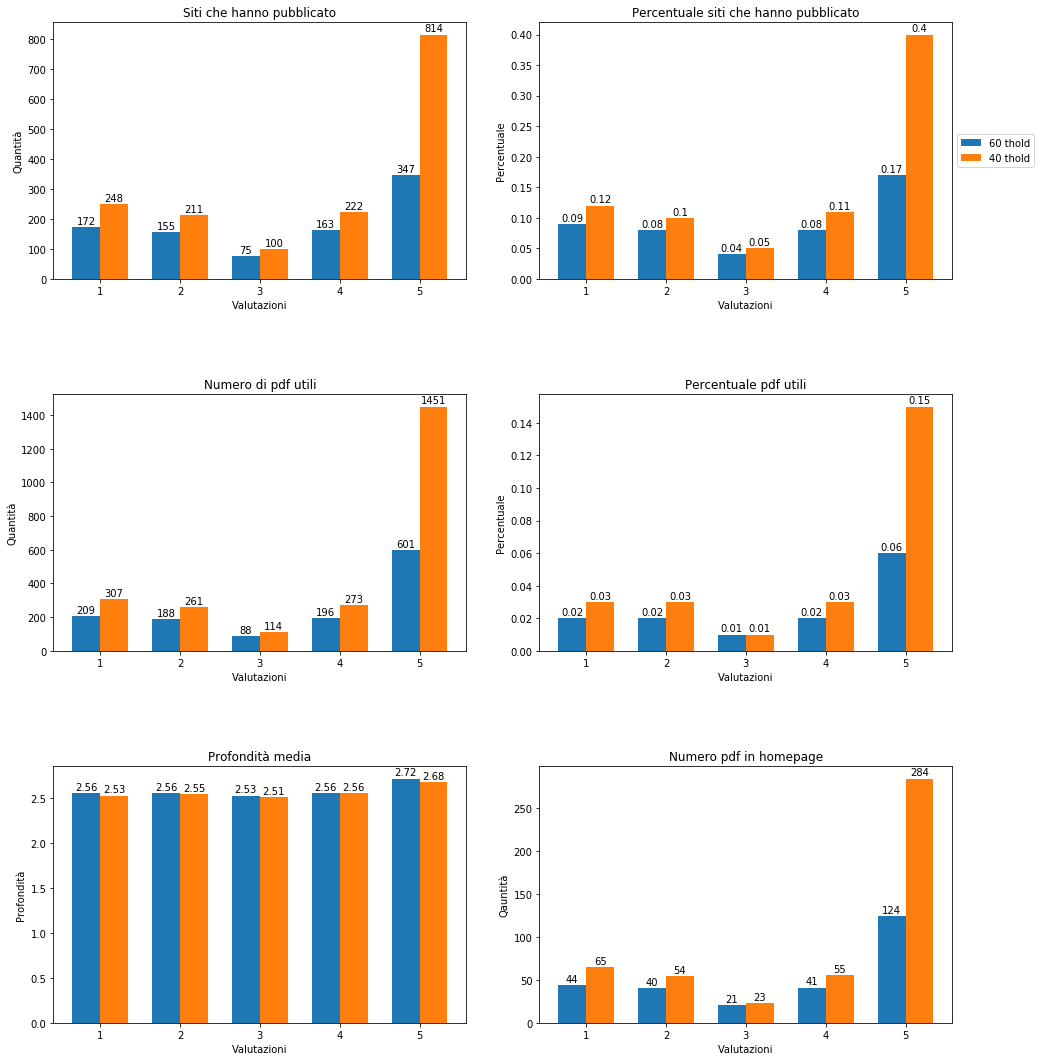

In [68]:
generate_plot(stp)

# Classificatore

Dopo un primo approccio con la funzione di valutazione, si è pensato alla creazione di un classificatore per i link.

Il modello usato è un __support vector machine__, visti gli ottimi risultati sulla lista completa di link.

## Dataset

Le features sono le stesse prese in considerazione dalla funzione di valutazione precedente, ovvero la presenza delle keyword sostenibilità, ambiente, report, bilancio e di 2018 negli elementi del link.

Il dataset è stato creato prendendo come sample positivi i link utili trovati dalla funzione discussa in precedenza, aggiungendo a mano alcuni esempi scartati, trovati riducendo il valore della threshold.

Per gli esempi negativi invece sono stati considerati i link che presentavano più caratteristiche positive, così da rendere il training più difficile e poter capire esattamente quali features determinassero l'utilità o meno di un documento.

In [57]:
dataset_path = "links_classifiers/data/dataset.csv"
data = pd.read_csv(dataset_path)
data.sample(n=5)

,k1_filename,k1_anchor,k1_url,k2_filename,k2_anchor,k2_url,k3_filename,k3_anchor,k3_url,k4_filename,k4_anchor,k4_url,18_filename,18_anchor,18_url,label
517,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,0
94,1,0,1,0,0,0,0,0,0,1,0,1,1,0,0,1
170,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1
438,0,1,0,1,0,1,0,0,0,1,1,1,0,0,0,0
708,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,0


## Training

A seguire il training del modello: per semplicità la funzione __generate_svm()__ restituisce un modello già allenato, il nome __c_8_0__ indica il caricamento del modello con parametro c = 8, quello con risultati migliori.

In [18]:
from sklearn import svm
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from links_classifiers import generate_svm

# generate_svm restituisce una svm allenata sul dataset successivo
s = generate_svm(load_name = 'c_8_0')

# split del training set per testare accuracy e confusion matrix
X = data[data.columns[:-1]]
Y = data.label
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

y_pred = s.predict(X_test)
print("Accuracy: {}".format(metrics.accuracy_score(y_test, y_pred)))
print("\nConfusion matrix:\n{}".format(metrics.confusion_matrix(y_test, y_pred)))

Accuracy: 0.9868421052631579

Confusion matrix:
[[119   2]
 [  1 106]]


## Link di esempio

Provando a riclassificare i link di esempio creati in precedenza, si nota che i link utili sono ritenuti positivi con una probabilità del 97 percento, mentre il link negativo, ma dubbio, risulta non utile al 64 percento.

In [14]:
from csv_links_processing import evaluate_classifier

ll = [
    {
        'pdfUrl' : 'www.test.it/sustainability/report-sostenibilità-2018.pdf',
        'anchor' : 'Scarica report sostenibilità'
    },
    {
        'pdfUrl' : 'www.test.it/docs/2018/report-ambientale.pdf',
        'anchor' : 'Download file'
    },
    {
        'pdfUrl' : 'www.test.it/home/documents/bilancio-economico-2018.pdf',
        'anchor' : 'Bilancio economico 2018'
    }
]

for l in ll:
    print("Prediction: %s \nProbability: %f \n" %evaluate_classifier(l, s))

Prediction: True 
Probability: 0.970575 

Prediction: True 
Probability: 0.969655 

Prediction: False 
Probability: 0.648720 



# File processing

Dopo aver ottenuto la lista di link utili dal classificatrore, i pdf sono stati scaricati e ne è stato estratto il contenuto.

Purtroppo il valore iniziale di riscontri si è ristretto a causa di problemi con alcuni file pdf, risultati non convertibili o scaricabili, sono presenti inoltre casi nei quali link differenti presenti su un sito web portano allo stesso file.

In [3]:
csv_source = "pdf_ocr/stats.csv"
data = pd.read_csv(csv_source) 
data

,stats,value
0,total files,373
1,file to process,198
2,file processed,187


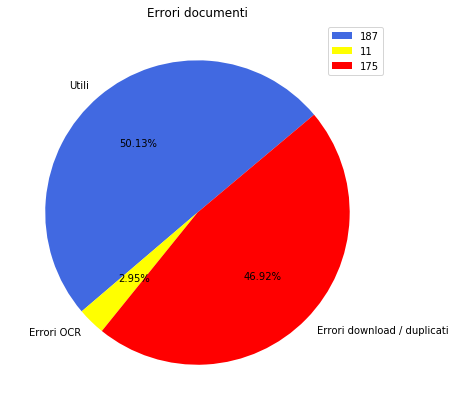

In [6]:
labels = 'Utili', 'Errori OCR', 'Errori download / duplicati'
val = list(data['value'])
sizes = [val[2], val[1] - val[2], val[0] - val[1]]
colors = ['royalblue', 'yellow', 'r']

fig1, ax = plt.subplots(figsize=(7,7))
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.2f%%', startangle=40)
ax.set_title("Errori documenti")
plt.legend(sizes, loc="best")

plt.show()

# Indicizzazione Elastic

Ottenuto il contenuto dei file è stato creato un indice elasticsearch, contenente:

1. id atoka dell'azienda
2. nome
3. indirizzo
4. ricavi
5. numero di dipendenti
6. testo contenuto nel documento pdf
7. entità principali del testo
8. tutte le entità del testo
9. url del file pdf
10. score della funzione evaluate sul singolo link

Le informazioni sulle aziende sono state ottenute con Atoka API, mentre quelle sulle entità tramite Dandelion API. 

## Statistiche popolazione

La popolazione dell'indice si basa su richieste alle API Atoka e Dandelion.
È possibile che alcuni report siano stati pubblicati da aziende le cui informazioni non siano totalmente o parzialmente reperibili tramite Atoka, alcuni pdf sono stati quindi scartati e sono presenti documenti elastic incompleti, che presentano ad esempio la mancanza dell'indirizzo dell'azienda, del codice ateco, dei ricavi o del numero di dipendenti.

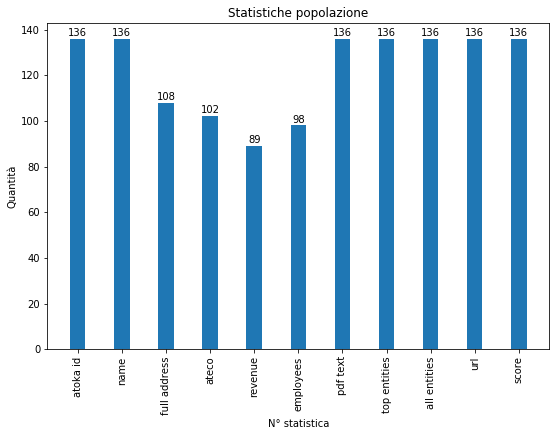

In [1]:
from elasticsearch_utilities import generate_plot

stats_path = "elasticsearch_utilities/stats/population.csv"
generate_plot(stats_path)

# Analisi: Latent Dirichlet Allocation

Per meglio capire gli argomenti trattati nei bilanci è stato usato un modello Latent Dirichlet Allocation.
L'insieme di parole per ogni documento è stato ottenuto dalle entità estratte con Dandelion, esse sono poi state tradotte in inglese poichè i documenti scaricati presentavano lingue differenti.

I modelli sono stati creati provando a considerare sia tutte le entità, che quelle principali.

# Modelli su tutte le entità

Il numero di entità presente per ogni documento è abbastanza alto, in media sono presenti __2496__ entità.

È stato creato un modello con l'insieme completo di entità, senza alcun vincolo, poi sono stati considerati dei vincoli di frequenza tra documenti e all'interno di un singolo documento.

## Modello senza vincoli di frequenza - entità complete

Il primo modello non presenta vicoli sulle keyword, si cercano quindi i topics considerando la lista completa di entità estratte dal testo.

### Preprocessing
Il primo passo sta nella preprocessazione dei dati: si parte dalla lista di entità per ogni documento, e si arriva alle strutture necessarie ad allenare il modello, ovvero:
1. _dtm_tf_ : frequency vector
2. _tf_vectorizer_ : count vectorizer contentente il vocabolario estratto dai documenti

In [4]:
csv_input = "elasticsearch_utilities/stats/input_all_entities_en.csv"

data = pd.read_csv(csv_input)
data.head()

,elastic_index,entities
0,1,Sustainability History Scientific_research Sus...
1,2,Rosia_Montana Value_added Recycling circular_E...
2,3,Sustainability Ohm's_law Sustainability Sustai...
3,4,List_of_Latin-script_digraphs Arkansas's_1st_c...
4,5,Sustainability Constitution Euro Revenue World...


L'input è preprocessato ottenendo le strutture utili a creare successivamente il modello.

In [5]:
from lda_topic_model import preprocess, print_vocab

dtm_tf, tf_vectorizer = preprocess("elasticsearch_utilities/stats/input_all_entities_en.csv")

print_vocab(tf_vectorizer.vocabulary_)

Total words in vocabulary : 21595

Words:
'sustainability' : 18563
'history' : 8961
'scientific_research' : 17005
'word' : 21275
'ceo' : 3435
...


### Creazione modello

Il modello viene creato partendo dai dati preprocessati, ovvero dalle entità trovate per ogni documento.

Lo scopo è quello di capire di cosa si parla nella raccola di documenti, andando a trovare degli argomenti formati dalle parole presenti in ogni documento.

### Parametri 
Nella creazione del modello bisogna tenere conto del numero di argomenti da trovare e di due parametri alpha e beta.

I valori di __alpha__ e __beta__ controllano rispettivamente:
1. quanti topics fanno parte di un documento: per un valore basso si assume che ogni documento sia composto da pochi topics 
2. quante parole compongono ogni topic: un valore più basso fa assumere al modello che ogni topic sia composto da poche keyword specifiche.
    
Per tutti i modelli che seguono, i parametri __topics__,  __alpha__ e __beta__ sono stati impostati per avere la maggior divisione e chiarezza possibile nella presentazione della distribuzione degli argomenti nei documenti.

In [6]:
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

topics = 13
alpha = 0.4
beta =  0.3

lda = LatentDirichletAllocation(n_components = topics, 
                                doc_topic_prior= alpha, 
                                topic_word_prior = beta, 
                                random_state=0)
lda.fit(dtm_tf)

pyLDAvis.sklearn.prepare(lda, dtm_tf, tf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.283223  0.047794       1        1  45.956031
10    -0.095947 -0.241032       2        1  15.421034
1      0.019901 -0.239028       3        1   8.020478
0     -0.151325  0.046258       4        1   7.513071
5     -0.125755  0.077806       5        1   7.235092
2     -0.119203  0.080539       6        1   4.908961
12     0.027029  0.084853       7        1   3.021595
3      0.106356 -0.065405       8        1   2.854393
11     0.113672 -0.041265       9        1   2.077107
4      0.083724  0.076916      10        1   1.844450
8      0.136306  0.053932      11        1   0.834138
6      0.149206  0.059672      12        1   0.298563
9      0.139259  0.058960      13        1   0.015086, topic_info=                                Term        Freq        Total Category  \
6232                      employment  5992.00000  5992.000000  Default   
18563                 sustainability  7292.00000  7292.000000  Default   
8856                          henkel  1209.00000  1209.000000  Default   
18585  sustainable_development_goals  1117.00000  1117.000000  Default   
18526                   supply_chain  2708.00000  2708.000000  Default   
...                              ...         ...          ...      ...   
20857                  wacker_chemie     0.00251     8.122452  Topic13   
18709              systematic_review     0.00251     4.913659  Topic13   
7084                    fermentation     0.00251    11.198435  Topic13   
12520                     montereale     0.00251     5.557910  Topic13   
2317          biological_agriculture     0.00251    23.368698  Topic13   

       logprob  loglift  
6232   30.0000  30.0000  
18563  29.0000  29.0000  
8856   28.0000  28.0000  
18585  27.0000  27.0000  
18526  26.0000  26.0000  
...        ...      ...  
20857  -9.9789   0.7171  
18709  -9.9789   1.2197  
7084   -9.9790   0.3959  
12520  -9.9790   1.0964  
2317   -9.9790  -0.3398  

[826 rows x 6 columns], token_table=       Topic      Freq                Term
term                                      
241        2  0.943158                  9p
285        2  0.956163          _decathlon
320        3  0.937752    _italian_petroli
341        2  0.988264              _nagel
381        6  0.776617                _son
...      ...       ...                 ...
21528      6  0.057055                zero
21528     10  0.028528                zero
21528     11  0.114110                zero
21538      2  0.007213  zf_friedrichshafen
21538      8  0.980947  zf_friedrichshafen

[2013 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 11, 2, 1, 6, 3, 13, 4, 12, 5, 9, 7, 10])

## Modello con vincoli di frequenza - entità complete

Per il modello che segue sono stati impostati dei vincoli di frequenza, un' entità viene considerata a patto che:
1. compaia in almeno __N__ documenti distinti
2. compaia almeno __M__ volte all'interno di un documento

L'obiettivo è quello di scartare quei termini strettamente legati al settore spefico della singola azienda autrice del bilancio e quei termini secondari all'interno di un documento.

### Grandezza vocabolario

A seguire la grandezza del vocabolario in relazione ai valori __N__ ed __M__.

Tenendo presente che:
- il __totale__ dei __documenti__ è di __170__.
- il numero __medio__ di __entità__ trovate in un testo è di __2496__

si può notare che anche valori molto piccoli di N ed M riducono di molto la grandezza del vocabolario.

Il grafico non presenta l'andamento completo, ma solo la parte iniziale in cui si nota un decremento esponenziale della dimensione.

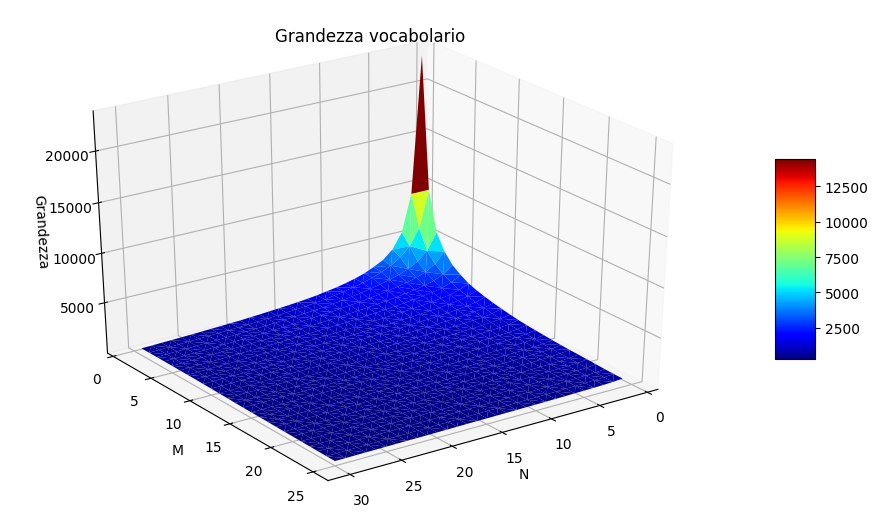

In [2]:
from lda_topic_model import generate_plot

stats_path = "lda_topic_model/data/vocabulary_stats_all_entities.csv"
generate_plot(stats_path)
plt.show()

### Modello

Il procedimento è lo stesso mostrato per il modello precedente, cambia la funzione di preprocessing che implementa le __restrizioni__ discusse sopra.

Avendo una restrizione sulla frequenza, è opportuno cambiare i parametri del modello, in particolare, si cercano __meno topics__, poichè con il vincolo di frequenza si eliminano gli argomenti troppo specifici per ogni documento. Come conseguenza sono cambiati opportunamente anche i parametri alpha e beta, coem discusso in precedenza.

A seguire il modello che considera solo i termini presenti in almeno il __25%__ dei __documenti__ e presenti almeno __15__ volte all'interno di un singolo documento.

In [7]:
from lda_topic_model import preprocess_freq_count

N = round(170 * 0.25)
M = 15

dtm_tf, tf_vectorizer = preprocess_freq_count("elasticsearch_utilities/stats/input_all_entities_en.csv", N, M)
print_vocab(tf_vectorizer.vocabulary_)

topics = 13
alpha = 0.4
beta = 0.7

topics = 10
alpha = 0.7
beta = 0.2


lda = LatentDirichletAllocation(n_components = topics, 
                                doc_topic_prior= alpha, 
                                topic_word_prior = beta, 
                                random_state=0)
lda.fit(dtm_tf)
pyLDAvis.sklearn.prepare(lda, dtm_tf, tf_vectorizer)

Total words in vocabulary : 237

Words:
'sustainability' : 206
'sustainable_development' : 207
'quality' : 160
'safety' : 177
'environment_' : 70
...


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.105825  0.067197       1        1  18.733453
3      0.101183  0.102063       2        1  17.205390
2      0.145995  0.017429       3        1  14.239671
8      0.043356  0.092486       4        1  12.543195
4     -0.337610  0.021360       5        1  12.147316
0     -0.338516  0.140213       6        1   8.876394
7      0.156540  0.029723       7        1   5.176531
1      0.167730  0.086313       8        1   5.100798
6     -0.005954 -0.304045       9        1   3.277035
5     -0.038550 -0.252739      10        1   2.700218, topic_info=                              Term         Freq        Total Category  \
206                 sustainability  7775.000000  7775.000000  Default   
208  sustainable_development_goals  1277.000000  1277.000000  Default   
67                      employment  6328.000000  6328.000000  Default   
125                        machine  1095.000000  1095.000000  Default   
75                            euro  1541.000000  1541.000000  Default   
..                             ...          ...          ...      ...   
114                     investment     0.831458   643.539369  Topic10   
128                  manufacturing     1.030341  1690.019047  Topic10   
13                        business     1.142350  3403.610926  Topic10   
37                        contract     0.568417   675.975635  Topic10   
204                   supply_chain     0.764598  2820.916945  Topic10   

     logprob  loglift  
206  30.0000  30.0000  
208  29.0000  29.0000  
67   28.0000  28.0000  
125  27.0000  27.0000  
75   26.0000  26.0000  
..       ...      ...  
114  -8.1740  -3.0397  
128  -7.9595  -3.7908  
13   -7.8563  -4.3877  
37   -8.5543  -3.4692  
204  -8.2578  -4.6014  

[503 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
0         4  0.439382    accounting
0         6  0.516920    accounting
1         1  0.317485   agriculture
1         4  0.193666   agriculture
1         5  0.476228   agriculture
...     ...       ...           ...
233      10  0.009625          work
234       4  0.976349     workforce
235       4  0.953209  working_time
236       6  0.599386         world
236       7  0.359632         world

[849 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 4, 3, 9, 5, 1, 8, 2, 7, 6])

# Modelli liste di entità principali

I modelli che seguono sono creati e visualizzati seguendo lo stesso procedimento mostrato sopra, utilizzano però la lista di __entità principali__.

La lista di entità questa volta non contiene doppioni, si può pensare alle entità principali come a un set ordinato per importanza, cambierà quindi il criterio di frequenza, essendo il precedente inapplicabile nella parte di conteggio delle occorrenze all'interno di ogni documento.  

Lo scopo è quello di isolare i termini ritenuti secondari e dunque ricavare dei __modelli__ più __specifici__.

Anche in questo caso è inizialmente considerato l'insieme totale di entità e successivamente quello ristretto per il nuovo criterio di frequenza, che questa volta non considererà il vincolo intra-documento.

## Modello senza vincoli di frequenza - entità principali

Il vocabolario è più ristretto rispetto al modello che considera tutte le entità del testo, è grande meno della metà. Bisogna però tenere presente che il numero medio di entità principali per ogni testo è di 250, molto minore di 2496, media del numero di entità complete.

In [8]:
dtm_tf, tf_vectorizer = preprocess("elasticsearch_utilities/stats/input_top_entities_en.csv")
print_vocab(tf_vectorizer.vocabulary_)

Total words in vocabulary : 8784

Words:
'sustainability' : 7592
'history' : 3617
'scientific_research' : 6943
'word' : 8663
'strategy' : 7495
...


Per la scelta dei parametri nel modello, si è __ridotto__ il numero di __topics__, sistemando quindi alpha e beta.

In [9]:
topics = 11
alpha = 0.02
beta =  0.07

lda = LatentDirichletAllocation(n_components = topics, 
                                doc_topic_prior= alpha, 
                                topic_word_prior = beta, 
                                random_state=0)
lda.fit(dtm_tf)
pyLDAvis.sklearn.prepare(lda, dtm_tf, tf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.287079 -0.031511       1        1  36.933866
9      0.053432 -0.219426       2        1  23.586356
6     -0.167956  0.038037       3        1   9.782013
2     -0.003513 -0.019958       4        1   8.570320
5      0.071596 -0.146279       5        1   7.710507
1     -0.015086  0.067865       6        1   4.766161
7     -0.063783  0.070855       7        1   3.454361
10     0.117943 -0.009362       8        1   2.161875
3      0.121138  0.122479       9        1   1.522202
4      0.084171  0.013516      10        1   0.971815
0      0.089137  0.113784      11        1   0.540525, topic_info=                           Term        Freq       Total Category  logprob  \
6684                      right  120.000000  120.000000  Default  30.0000   
4142                      italy   86.000000   86.000000  Default  29.0000   
1046                   business  275.000000  275.000000  Default  28.0000   
4695                 management  127.000000  127.000000  Default  27.0000   
2329                  economics  334.000000  334.000000  Default  26.0000   
...                         ...         ...         ...      ...      ...   
5256                netherlands    0.309673   18.558314  Topic11  -6.4840   
1174  carbon_dioxide_equivalent    0.264022   19.674666  Topic11  -6.6434   
5145                    mutagen    0.262310    1.594268  Topic11  -6.6499   
2372            electric_charge    0.262310    1.711105  Topic11  -6.6499   
7038                     sewage    0.262310    2.230882  Topic11  -6.6499   

      loglift  
6684  30.0000  
4142  29.0000  
1046  28.0000  
4695  27.0000  
2329  26.0000  
...       ...  
5256   1.1272  
1174   0.9093  
5145   3.4157  
2372   3.3450  
7038   3.0798  

[1039 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
0         7  0.558057               100
11       10  0.790715              1963
12       10  0.790715              1984
31        6  1.003616          2_rocket
47        4  0.947948      42nd_street_
...     ...       ...               ...
8687      6  0.067440             world
8687      8  0.016860             world
8687     10  0.016860             world
8723      9  1.007377           xylitol
8735      9  1.007377  yg_entertainment

[1869 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 10, 7, 3, 6, 2, 8, 11, 4, 5, 1])

## Modello con vincoli di frequenza - entità principali

Il criterio per il vincolo di frequenza cambia: 
1. __N__ rimane lo stesso, ovvero specifica la __frequenza inter-documento__ di un' entità.
2. __M__ questa volta diventa la __quantità__ di __entità considerate__ per ogni documento. Un paramentro piccolo indicherà la considerazione delle parole più importanti, mentre un paramentro alto comprenderà una quantità di parole, meno importanti, più elevata.

Per quanto riguarda la restrizione di frequenza inter-documento, ovvero sul parametro N, l'andamento della curva decresce in modo esponenziale, in linea con la curva nell'esempio precedente.

Per quanto riguarda il paramentro M, questa volta porta ad un incremento lineare del vocabolario, poichè ad ogni step si include un numero di entità proporzionale al totale dei documenti.

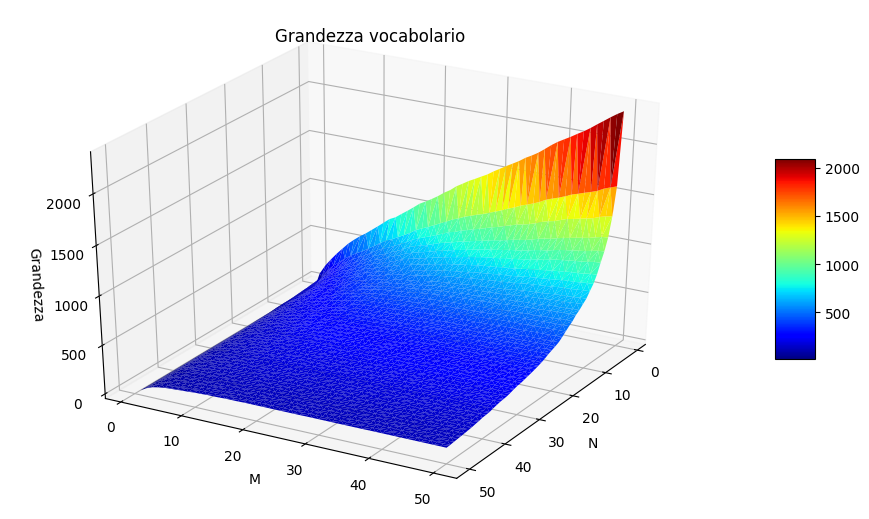

In [3]:
stats_path = "lda_topic_model/data/vocabulary_stats_top_entities.csv"
generate_plot(stats_path, en="top")

Il modelli che seguono mantengono la restrizione della frequenza adottata in precedenza per quanto riguarda N, ovvero si considerano i termini presenti nel __25%__ dei __documenti__, mentre per __M__ si usano __50__ e __30__ rispettivamente.

### M = 50

In [12]:
from lda_topic_model import preprocess_freq_count_relevant

N = round(170 * 0.25)
M = 50

dtm_tf, tf_vectorizer = preprocess_freq_count_relevant("elasticsearch_utilities/stats/input_top_entities_en.csv", N, M)
print_vocab(tf_vectorizer.vocabulary_)

topics = 10
alpha = 0.9
beta = 0.2

lda = LatentDirichletAllocation(n_components = topics, 
                                doc_topic_prior= alpha, 
                                topic_word_prior = beta, 
                                random_state=0)
lda.fit(dtm_tf)
pyLDAvis.sklearn.prepare(lda, dtm_tf, tf_vectorizer)

Total words in vocabulary : 137

Words:
'strategy' : 115
'sustainable_development' : 118
'risk_management' : 100
'quality' : 90
'safety' : 101
...


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.153887  0.122014       1        1  16.046258
6      0.167011  0.027197       2        1  14.280462
7     -0.228088 -0.020500       3        1  14.138812
8      0.187144  0.028081       4        1  12.748589
2     -0.024293 -0.105896       5        1   8.522804
4     -0.264938  0.148644       6        1   8.158822
0      0.016318 -0.173487       7        1   7.667027
1      0.106078  0.068184       8        1   6.383440
9      0.029811 -0.082851       9        1   6.240251
3     -0.142929 -0.011386      10        1   5.813535, topic_info=             Term       Freq      Total Category  logprob  loglift
47        finance  34.000000  34.000000  Default  30.0000  30.0000
30      economics  70.000000  70.000000  Default  29.0000  29.0000
136         world  29.000000  29.000000  Default  28.0000  28.0000
2        behavior  31.000000  31.000000  Default  27.0000  27.0000
23        culture  30.000000  30.000000  Default  26.0000  26.0000
..            ...        ...        ...      ...      ...      ...
31        economy   0.706555  42.968855  Topic10  -5.5695  -1.2628
104       service   0.419004  20.502797  Topic10  -6.0920  -1.0455
90        quality   0.370476  18.877197  Topic10  -6.2151  -1.0859
37   environment_   0.401437  34.157628  Topic10  -6.1349  -1.5987
30      economics   0.432548  70.033876  Topic10  -6.0602  -2.2421

[397 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
0         1  0.557800  air_pollution
0         2  0.223120  air_pollution
0         4  0.167340  air_pollution
1         1  0.744733          audit
2         2  0.126727       behavior
...     ...       ...            ...
136       2  0.034248          world
136       3  0.068496          world
136       5  0.034248          world
136       9  0.136991          world
136      10  0.650708          world

[460 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 7, 8, 9, 3, 5, 1, 2, 10, 4])

### M = 30

In [13]:
N = round(170 * 0.25)
M = 30

dtm_tf, tf_vectorizer = preprocess_freq_count_relevant("elasticsearch_utilities/stats/input_top_entities_en.csv", N, M)
print_vocab(tf_vectorizer.vocabulary_)

topics = 10
alpha = 0.7
beta = 0.3

lda = LatentDirichletAllocation(n_components = topics, 
                                doc_topic_prior= alpha, 
                                topic_word_prior = beta, 
                                random_state=0)
lda.fit(dtm_tf)
pyLDAvis.sklearn.prepare(lda, dtm_tf, tf_vectorizer)

Total words in vocabulary : 136

Words:
'strategy' : 114
'sustainable_development' : 117
'risk_management' : 100
'quality' : 90
'safety' : 101
...


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.133297  0.013475       1        1  19.213564
7      0.250483  0.012867       2        1  17.430724
2     -0.158700 -0.068481       3        1  15.637656
0      0.101450 -0.086587       4        1   9.708194
1     -0.077501  0.164909       5        1   9.448096
8     -0.051216 -0.177596       6        1   7.910089
9      0.017814 -0.055420       7        1   6.696636
5     -0.042440  0.085191       8        1   4.908940
4      0.038505  0.082485       9        1   4.647673
3      0.054904  0.029158      10        1   4.398428, topic_info=                Term       Freq      Total Category  logprob  loglift
30         economics  39.000000  39.000000  Default  30.0000  30.0000
127           value_  35.000000  35.000000  Default  29.0000  29.0000
92         recycling  16.000000  16.000000  Default  28.0000  28.0000
135            world  16.000000  16.000000  Default  27.0000  27.0000
42              euro  22.000000  22.000000  Default  26.0000  26.0000
..               ...        ...        ...      ...      ...      ...
69        management   0.389985  27.724751  Topic10  -5.4650  -1.1400
100  risk_management   0.379811  11.592166  Topic10  -5.4915  -0.2945
37      environment_   0.388440  29.795571  Topic10  -5.4690  -1.2161
15           company   0.392282  56.361128  Topic10  -5.4592  -1.8436
4            biology   0.385455  29.793879  Topic10  -5.4767  -1.2237

[434 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
0         1  0.645471  air_pollution
0         8  0.092210  air_pollution
0         9  0.092210  air_pollution
1         7  0.439526          audit
2         3  0.523803       behavior
...     ...       ...            ...
133       2  0.833518           work
133       4  0.046307           work
134       1  0.396496      workforce
135       2  0.121082          world
135      10  0.726492          world

[359 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 8, 3, 1, 2, 9, 10, 6, 5, 4])